# Import packages

In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize()

import numpy as np
import sys 
sys.path.append("../..") 

%aimport preprocessing
%aimport utils
%aimport p2v

from sklearn.manifold import TSNE

from utils import prinT
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [5]:
k_list = [10, 10, 10, 10, 10, 10, 10]
start_year_list = ['1950', '1960', '1970', '1980', '1990', '2000', '2010']
end_year_list = ['1959', '1969', '1979', '1989', '1999', '2009', '2021']

# Functions for processing time series

In [5]:
def filter_nan_in_middle(x):
    val_list = x.to_list()
    
    start_idx = -1
    end_idx = -1
    nan_in_middle = False
    for i in range(0, len(val_list)):
        if not np.isnan(val_list[i]):
            start_idx = i
            break
    for i in range(len(val_list)-1, -1, -1):
        if not np.isnan(val_list[i]):
            end_idx = i
            break
    for i in range(start_idx, end_idx):
        if np.isnan(val_list[i]):
            nan_in_middle = True
            break
    if start_idx == end_idx:
        len_of_1 = True
    else :
        len_of_1 = False
    return nan_in_middle, len_of_1, start_idx, end_idx

# Generate a dataframe which contains periodical's local semantic change

In [5]:
from sklearn.metrics.pairwise import cosine_similarity, paired_distances

def cal_local_distance(x, tar_neighbor_idxs, ref_neighbor_idxs, tar_vectors, ref_vectors):
    neighbor_idx_list = list(set(tar_neighbor_idxs[x]).union(set(ref_neighbor_idxs[x])))
    tar_neighbor_vectors = [tar_vectors[idx] for idx in neighbor_idx_list]
    ref_neighbor_vectors = [ref_vectors[idx] for idx in neighbor_idx_list]
    tar_focal_vector = tar_vectors[x]
    ref_focal_vector = ref_vectors[x]

    tar_second_order_change = cosine_similarity(tar_focal_vector.reshape(1,-1), tar_neighbor_vectors)
    ref_second_order_change = cosine_similarity(ref_focal_vector.reshape(1,-1), ref_neighbor_vectors)

    return paired_distances(tar_second_order_change, ref_second_order_change, metric='cosine')[0]

In [6]:
model = p2v.P2V()

local_semantic_change_df = pd.DataFrame(columns=['VID'])
col_name_list = ['semantic_change_1960s', 
                 'semantic_change_1970s', 
                 'semantic_change_1980s',
                 'semantic_change_1990s',
                 'semantic_change_2000s',
                 'semantic_change_2010s']

for i in range(0, 6):
    old_start_year, old_end_year = start_year_list[i], end_year_list[i]
    new_start_year, new_end_year = start_year_list[i+1], end_year_list[i+1]
    print("-----------------------")
    prinT("start comparing {}-{} with the {}-{}".format(old_start_year, old_end_year, new_start_year, new_end_year))

    old_wv = model.load_wv(old_start_year, old_end_year, 100, 10)
    new_wv = model.load_wv(new_start_year, new_end_year, 100, 10)
    
    old_VIDs = old_wv.index_to_key
    new_VIDs = new_wv.index_to_key
    shared_VIDs = list(set(old_VIDs) & set(new_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))
    
    old_idx = [old_wv.get_index(VID) for VID in shared_VIDs]
    new_idx = [new_wv.get_index(VID) for VID in shared_VIDs]
    
    old_vectors = old_wv.get_normed_vectors()[old_idx]
    new_vectors = new_wv.get_normed_vectors()[new_idx]

    prinT("finish, start generate neighbor union...")
    old_neighbor_idxs = np.argsort(cosine_similarity(old_vectors, old_vectors))[:, -2:-k_list[i]-2:-1]
    new_neighbor_idxs = np.argsort(cosine_similarity(new_vectors, new_vectors))[:, -2:-k_list[i+1]-2:-1]
    
    prinT("start cal local neighbor distance...")
    dist_df = pd.DataFrame({'VID': shared_VIDs})
    dist = dist_df.index.to_series().parallel_apply(cal_local_distance, args=(old_neighbor_idxs, 
                                                                              new_neighbor_idxs, 
                                                                              old_vectors, 
                                                                              new_vectors))
    prinT("finish")

    dist_df[col_name_list[i]] = dist
    local_semantic_change_df = local_semantic_change_df.merge(dist_df, on='VID', how='outer')
    local_semantic_change_df['total_semantic_change_'+new_start_year+'s'] = local_semantic_change_df[col_name_list[0:i+1]].sum(axis=1)

2024-04-26 21:06:24 -- start loading Mag_venue_info_df
2024-04-26 21:06:24 -- finish.
2024-04-26 21:06:24 -- start loading labeled_journal_info_df
2024-04-26 21:06:24 -- finish.
-----------------------
2024-04-26 21:06:24 -- start comparing 1950-1959 with the 1960-1969
2024-04-26 21:06:24 -- start loading word vectors...
2024-04-26 21:06:24 -- word vectors loaded, and its shape is: (1645, 100)
2024-04-26 21:06:24 -- start loading word vectors...
2024-04-26 21:06:24 -- word vectors loaded, and its shape is: (3116, 100)
2024-04-26 21:06:24 -- the number of shared VIDs between this two decades: 1500
2024-04-26 21:06:24 -- finish, start generate neighbor union...
2024-04-26 21:06:24 -- start cal local neighbor distance...
2024-04-26 21:06:25 -- finish
-----------------------
2024-04-26 21:06:25 -- start comparing 1960-1969 with the 1970-1979
2024-04-26 21:06:25 -- start loading word vectors...
2024-04-26 21:06:25 -- word vectors loaded, and its shape is: (3116, 100)
2024-04-26 21:06:25 -- 

In [7]:
# Labelling
local_semantic_change_df.loc[:,'venue_name'] = local_semantic_change_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
# Using the lastes decade's labels
VID_labele_dict = model.load_VID_labeled(2010, 2021, 100, 10)
local_semantic_change_df['scopus_label'] = local_semantic_change_df.VID.map(lambda x: VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                                                            else np.nan)

2024-04-26 21:07:33 -- start loading VID_labeled...
2024-04-26 21:07:33 -- finish.


In [8]:
# incorrect venues in MAG
corrupted_venue_name_list = ['Japanese Journal of Pharmacology', 
                             'Journal of Computers',
                             'Journal of Algorithms',
                             'Journal of Agricultural Engineering Research',
                             'Sozial-und Praventivmedizin',
                             'Scientia Forestalis',
                             'Interpretation',
                             'Genes',
                             'Protein Science',
                             'Hospital Medicine',
                             'Immunotechnology',
                             'Journal of Ayurveda and Integrative Medicine',
                             'Versus',
                             'Tradition',
                             'ACM Transactions on Cyber-Physical Systems',
                             'Journal of Biomedical Engineering',
                             'Antibiotics and Chemotherapy',
                             'Social Work',
                             'Production Journal',
                             'Insight',
                             'Sats',
                             'English',
                             'Leonardo',
                             'The Forum',
                             'Chemical Industry',
                             'The American review of respiratory disease',
                             'Chemistry & Industry',
                             'Lawrence Berkeley National Laboratory',
                             'international symposium on open collaboration',
                             'Scopus',
                             'Technical reports',
                             'The annual research report',
                             'Biosilico',
                             '0',
                             'Computer Science and Its Applications',
                             'Journal of Programming Languages',
                             'Fuel and Energy Abstracts',
                            ]

In [9]:
# Filtering
local_semantic_change_df = local_semantic_change_df[~(local_semantic_change_df.venue_name.isin(corrupted_venue_name_list))]
local_semantic_change_df[['nan_in_middle', 
                          'len_of_1', 
                          'start_idx', 
                          'end_idx']] = local_semantic_change_df[col_name_list].apply(filter_nan_in_middle, axis=1, result_type='expand')
# Make sure that each time series never interrupts and has a value for the lastest decade
local_semantic_change_df = local_semantic_change_df[(local_semantic_change_df.nan_in_middle==False) & (local_semantic_change_df.end_idx==5)]

In [10]:
# save as .pkl file
local_semantic_change_df.to_pickle('local_semantic_change_k_10.pkl')

# Load the pre-generated DataFrame from the local file

In [6]:
model = p2v.P2V()
local_semantic_change_df = pd.read_pickle('local_semantic_change_k_10.pkl')

2024-10-14 15:08:20 -- start loading Mag_venue_info_df
2024-10-14 15:08:20 -- finish.
2024-10-14 15:08:20 -- start loading labeled_journal_info_df
2024-10-14 15:08:20 -- finish.


# Plot single periodical's local semantic change in every decade

In [7]:
abbr_dict = {
    'Bulletin of Mathematical Biology': 'Bull. Math. Biol.',
    'meeting of the association for computational linguistics': 'ACL',
    'Journal of the Acoustical Society of America': 'J. Acoust. Soc. Am.',

    'Proceedings of The Royal Society B: Biological Sciences': 'Proc. R. Soc. B',
    'Yale Journal of Biology and Medicine': 'Yale J. Biol. Med.',
    'Philosophical Transactions of the Royal Society B': 'Philos. Trans. R. Soc. B',

    'Quarterly Journal of Economics': 'QJE', 
    'Annals of Mathematics':'Ann. Math.',
    'American Sociological Review': 'ASR',
    }

c:\Users\lyuzhuoqi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)
c:\Users\lyuzhuoqi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)
c:\Users\lyuzhuoqi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)
c:\Users\lyuzhuoqi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)
c:\Users\lyuzhuoqi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a 

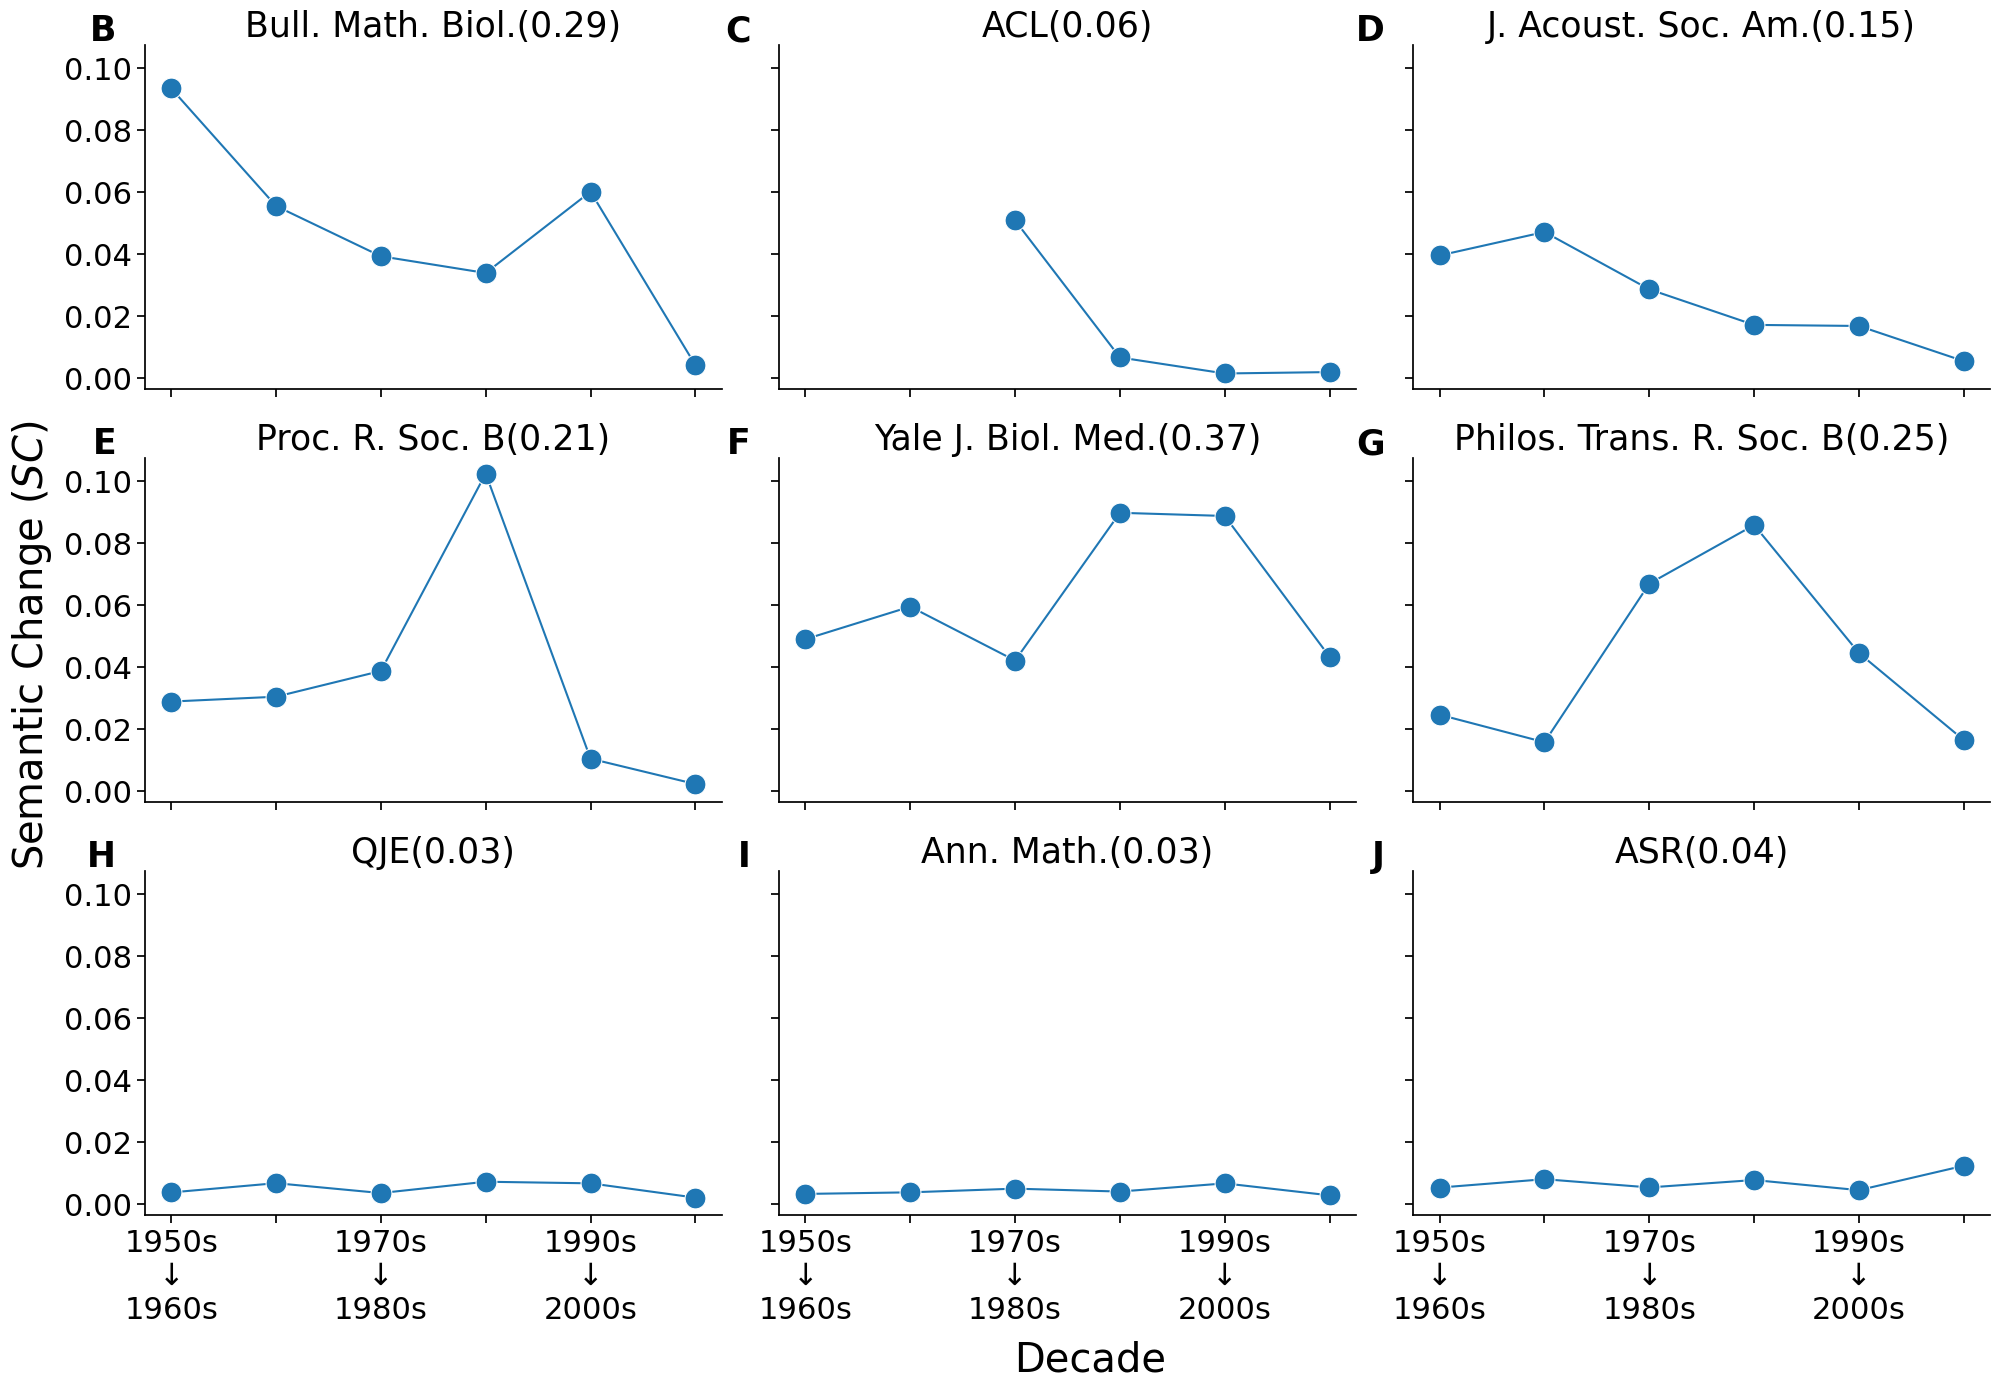

In [11]:
local_semantic_change_df_rename = local_semantic_change_df[local_semantic_change_df.venue_name.isin(abbr_dict.keys())].copy()
local_semantic_change_df_rename.venue_name = local_semantic_change_df_rename.venue_name.replace(abbr_dict)

local_semantic_change_df_wide = pd.wide_to_long(local_semantic_change_df_rename,
                                                stubnames=['semantic_change'],
                                                suffix='.+',
                                                sep='_',
                                                i = ['venue_name'],
                                                j = 'decade')

with sns.plotting_context("notebook", font_scale=2):
    g1 = sns.relplot(data=local_semantic_change_df_wide,
                    x='decade', y='semantic_change',
                    legend=False,
                    col='venue_name', col_order=abbr_dict.values(), col_wrap=3, aspect=1.5, 
                    kind='line', marker='o', markersize=15)
    g1.set(xticklabels=['1950s\n↓\n1960s', '1960s\n↓\n1970s','1970s\n↓\n1980s','1980s\n↓\n1990s','1990s\n↓\n2000s','2000s\n↓\n2010s',])

    # Generate titles (abbr+(change value))
    title_list = []
    for abbr in abbr_dict.values():
        total_change = local_semantic_change_df_rename[local_semantic_change_df_rename.venue_name == abbr].total_semantic_change_2010s.values[0]
        title_list.append(abbr + '('+ f"{total_change:.{2}f}" + ')')
        
    pannel_labels = list("BCDEFGHIJ")
    for i in range(len(g1.axes.flat)):
        ax = g1.axes.flat[i]

        # Only show a half of xlabels
        labels = ax.get_xticklabels()
        for j, label in enumerate(labels):
            if j % 2 != 0:
                label.set_visible(False)

        # Plot pannel labels
        ax.text(-0.05, 1.09, pannel_labels[i], transform=ax.transAxes, 
                fontsize=25, fontweight='bold', va='top', ha='right')

        ax.set_title(title_list[i], fontsize=25) 
        
    g1.set_ylabels('')
    g1.set_xlabels('')
    g1.figure.supylabel(r'Semantic Change ($SC$)')
    g1.figure.supxlabel('Decade')
    g1.figure.subplots_adjust(left=0.08, right=0.9, top=0.9, bottom=0.12, wspace=0.1, hspace=0.2)

plt.show()

In [12]:
g1.savefig('single_periodical_local_semantic_change_k_10.pdf',
          facecolor='white', 
          transparent=False, 
          bbox_inches='tight')

# Plot the distribution of periodicals' total semantic change

In [14]:
abbr_dict = {# 1950s
             'CA: A Cancer Journal for Clinicians':'CA: Cancer J. Clin.',
             'Quarterly Journal of Economics': 'QJE', 
             'Econometrica': 'Econometrica', 
             'Psychological Bulletin': 'Psychol. Bull.',
             'Chemical Reviews': 'Chem. Rev.',
             'JAMA': 'JAMA',
             'Science': 'Science',
             'Nature': 'Nature',
             'Proceedings of the National Academy of Sciences of the United States of America': 'PNAS',
             'Physical Review Letters': 'PRL',
             'The New England Journal of Medicine': 'NEJM',
             'American Sociological Review': 'ASR',
             'Annals of Mathematics':'Ann. Math.',
             'The Lancet': 'Lancet',
             'BMJ': 'BMJ',
             'Proceedings of The Royal Society B: Biological Sciences': 'Proc. R. Soc. B',
    
             # 1960s
             'Atmosphere':'Atmosphere',
             'Language Learning': 'Lang. Learn.',
             'Automatica': 'Automatica',
             'Materials Research Bulletin': 'Mater. Res. Bull.',
             'Carbon':'Carbon',
             'Stanford Law Review': 'SLR',
             'Computing': 'Computing',
             'Journal of Applied Crystallography': 'J. Appl. Crystallogr.',
             'Ultrasonics': 'Ultrasonics',
             'IEEE Transactions on Nuclear Science': 'IEEE Trans Nucl Sci',
             'IEEE Transactions on Biomedical Engineering': 'IEEE. Trans. Biomed. Eng.',
             'Pattern Recognition': 'Pattern Recognit.',
             'Physics Letters B': 'PLB',
             'Journal of Financial and Quantitative Analysis': 'JFQA',
                
             # 1970s
             'Studies in Second Language Acquisition':'Stud. Second Lang. Acquis.',
             'Linguistic Inquiry': 'Linguist. Inq.',
             'European Journal of Political Research': 'EJPR',
             'Accounting Organizations and Society': 'Account. Organ. Soc.',
             'Clinical Infectious Diseases': 'Clin. Infect. Dis.',
             'Economic Analysis and Policy': 'Econ Anal Policy',
             'Research Policy': 'Res. Policy',
             'Gene': 'Gene',
             'Pain': 'Pain',
             'Social Networks': 'Soc. Netw.',
             'Life sciences in space research': 'Life Sci Space Res',
             'Computational Biology and Chemistry': 'Comput Biol Chem',
             'Civil Engineering': 'C.E.J',
             'Journal of Biosciences': 'J. Biosci.',
             'Cell': 'Cell',
    
             # 1980s
             'Applied Linguistics':'Appl. Linguist.',
             'Journal of Accounting and Economics': 'J. Account. Econ.',
             'Journal of Accounting and Public Policy': 'JAPP',
             'Journal of Physics: Condensed Matter': 'J. Phys. Condens. Matter',
             'Transport Reviews': 'Transp. Rev.',
             'European Management Journal': 'EMJ',
             'International Journal of Remote Sensing': 'Int. J. Remote Sens.',
             'Stem Cells': 'Stem Cells',
             'Journal of Chemometrics': 'J. Chemom.',
             'Bioelectromagnetics': 'Bioelectromagnetics',
             'neural information processing systems': 'NeurIPS',
             'IEEE Transactions on Medical Imaging': 'IEEE TMI',

             # 1990s
             'The Accounting Review': 'Account. Rev.',
             'Human Resource Management Journal': 'Hum. Resour. Manag. J.',
             'Cancer Cell': 'Cancer Cell',
             'IEEE Transactions on Applied Superconductivity': 'IEEE TAS',
             'Cell Research': 'Cell Res.',
             'the web conference': 'TheWebConf',
             'knowledge discovery and data mining': 'KDD',
             'empirical methods in natural language processing': 'EMNLP',
             'Materials': 'Materials',
             'Sensors': 'Sensor',
             'Complexity': 'Complexity',

             # 2000s
             'PLOS ONE': 'PLOS ONE',
             'Nature Reviews Immunology': 'Nat. Rev. Immunol.',
             'Nature Materials': 'Nat. Mater',
             'Lancet Oncology': 'Lancet Oncol.',
             'Nature Photonics': 'Nat. Photonics',
             'Obesity': 'Obesity',
             'Nature Chemical Biology': 'Nat. Chem. Biol.',
             'IEEE Transactions on Industrial Informatics': 'IEEE TII',
             'BMC Research Notes': 'BMC Res. Notes',
            }

display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==0)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==1)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==2)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==3)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==4)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==5)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))

,venue_name,total_semantic_change_2010s
979,Science,0.287024
85,Nature,0.236174
1091,Proceedings of The Royal Society B: Biological Sciences,0.213366
1320,Proceedings of the National Academy of Sciences of the United States of America,0.118479
565,CA: A Cancer Journal for Clinicians,0.101693
852,The Lancet,0.081893
1330,BMJ,0.081287
193,JAMA,0.071073
511,Chemical Reviews,0.067259
1325,Psychological Bulletin,0.065976


,venue_name,total_semantic_change_2010s
2752,Computing,0.143258
2145,Journal of Applied Crystallography,0.133903
2665,Ultrasonics,0.114737
2526,IEEE Transactions on Biomedical Engineering,0.107451
1552,IEEE Transactions on Nuclear Science,0.098244
1639,Stanford Law Review,0.078532
1677,Carbon,0.069954
2401,Pattern Recognition,0.053555
2093,Materials Research Bulletin,0.044917
2463,Automatica,0.042407


,venue_name,total_semantic_change_2010s
3986,Civil Engineering,0.172058
5157,Journal of Biosciences,0.125350
3012,Computational Biology and Chemistry,0.123034
3270,Social Networks,0.080673
4159,Economic Analysis and Policy,0.071009
3880,Pain,0.069803
3592,Gene,0.058725
5418,Research Policy,0.051471
4466,Cell,0.035209
4761,Accounting Organizations and Society,0.019095


,venue_name,total_semantic_change_2010s
6200,Bioelectromagnetics,0.186162
6090,Journal of Chemometrics,0.087950
8791,Stem Cells,0.076019
6350,neural information processing systems,0.054346
6020,IEEE Transactions on Medical Imaging,0.052444
6496,Transport Reviews,0.026843
7969,European Management Journal,0.021246
7487,Journal of Physics: Condensed Matter,0.014341
5875,International Journal of Remote Sensing,0.013371
8290,Journal of Accounting and Public Policy,0.009999


,venue_name,total_semantic_change_2010s
14253,Complexity,0.163474
10661,Sensors,0.077237
9899,Materials,0.064257
10824,Cell Research,0.038559
14290,the web conference,0.028615
11687,Cancer Cell,0.025142
14188,IEEE Transactions on Applied Superconductivity,0.017895
14504,knowledge discovery and data mining,0.012565
14682,empirical methods in natural language processing,0.009595
12940,Human Resource Management Journal,0.008474


,venue_name,total_semantic_change_2010s
15475,BMC Research Notes,0.069128
23772,IEEE Transactions on Industrial Informatics,0.018275
15477,PLOS ONE,0.017105
20368,Nature Chemical Biology,0.015277
17949,Obesity,0.006260
21064,Nature Photonics,0.003819
19406,Nature Reviews Immunology,0.002754
22769,Nature Materials,0.002715
25593,Lancet Oncology,0.002349


In [15]:
# a cell used for looking for periodicals to display
local_semantic_change_df[(local_semantic_change_df['start_idx']==1) & (local_semantic_change_df['total_semantic_change_2010s']<=0.045)].sort_values('total_semantic_change_2010s', ascending=False).head(20)

,VID,semantic_change_1960s,total_semantic_change_1960s,semantic_change_1970s,total_semantic_change_1970s,semantic_change_1980s,total_semantic_change_1980s,semantic_change_1990s,total_semantic_change_1990s,semantic_change_2000s,total_semantic_change_2000s,semantic_change_2010s,total_semantic_change_2010s,venue_name,scopus_label,nan_in_middle,len_of_1,start_idx,end_idx
1808,3.734910e+07,NaN,NaN,0.011417,0.011417,0.013187,0.024604,0.009687,0.034291,0.008188,0.042479,0.002520,0.044999,Journal of Mass Spectrometry,Chemistry,False,False,1,5
2093,1.385301e+08,NaN,NaN,0.009758,0.009758,0.011426,0.021183,0.017600,0.038784,0.002606,0.041390,0.003527,0.044917,Materials Research Bulletin,Materials Science,False,False,1,5
1926,1.303372e+08,NaN,NaN,0.020145,0.020145,0.007652,0.027797,0.010724,0.038521,0.003429,0.041950,0.002789,0.044739,Gerontologist,Medicine,False,False,1,5
2462,8.806114e+07,NaN,NaN,0.014426,0.014426,0.011329,0.025756,0.007760,0.033516,0.008324,0.041840,0.002868,0.044707,International Journal of Control,Engineering,False,False,1,5
2091,5.303612e+06,NaN,NaN,0.011988,0.011988,0.004896,0.016884,0.009832,0.026717,0.011106,0.037822,0.006866,0.044688,AORN Journal,Nursing,False,False,1,5
1776,1.647018e+08,NaN,NaN,0.007908,0.007908,0.015232,0.023141,0.005196,0.028337,0.006265,0.034602,0.010041,0.044642,Critical Studies in Education,Social Sciences,False,False,1,5
2549,9.328812e+07,NaN,NaN,0.010972,0.010972,0.013602,0.024574,0.006885,0.031459,0.007691,0.039149,0.005350,0.044499,Medical Mycology,Medicine,False,False,1,5
1501,5.422285e+07,NaN,NaN,0.015311,0.015311,0.008362,0.023673,0.006793,0.030466,0.012661,0.043127,0.001344,0.044471,International Ophthalmology Clinics,Medicine,False,False,1,5
2059,9.668518e+07,NaN,NaN,0.019537,0.019537,0.008599,0.028136,0.002701,0.030837,0.005054,0.035891,0.008539,0.044430,Theoretical and Applied Genetics,Agricultural and Biological Sciences,False,False,1,5
2371,1.350663e+08,NaN,NaN,0.018307,0.018307,0.005642,0.023949,0.004596,0.028545,0.010432,0.038977,0.005414,0.044391,Theoretical and Mathematical Physics,Mathematics,False,False,1,5


<Figure size 1920x1440 with 0 Axes>

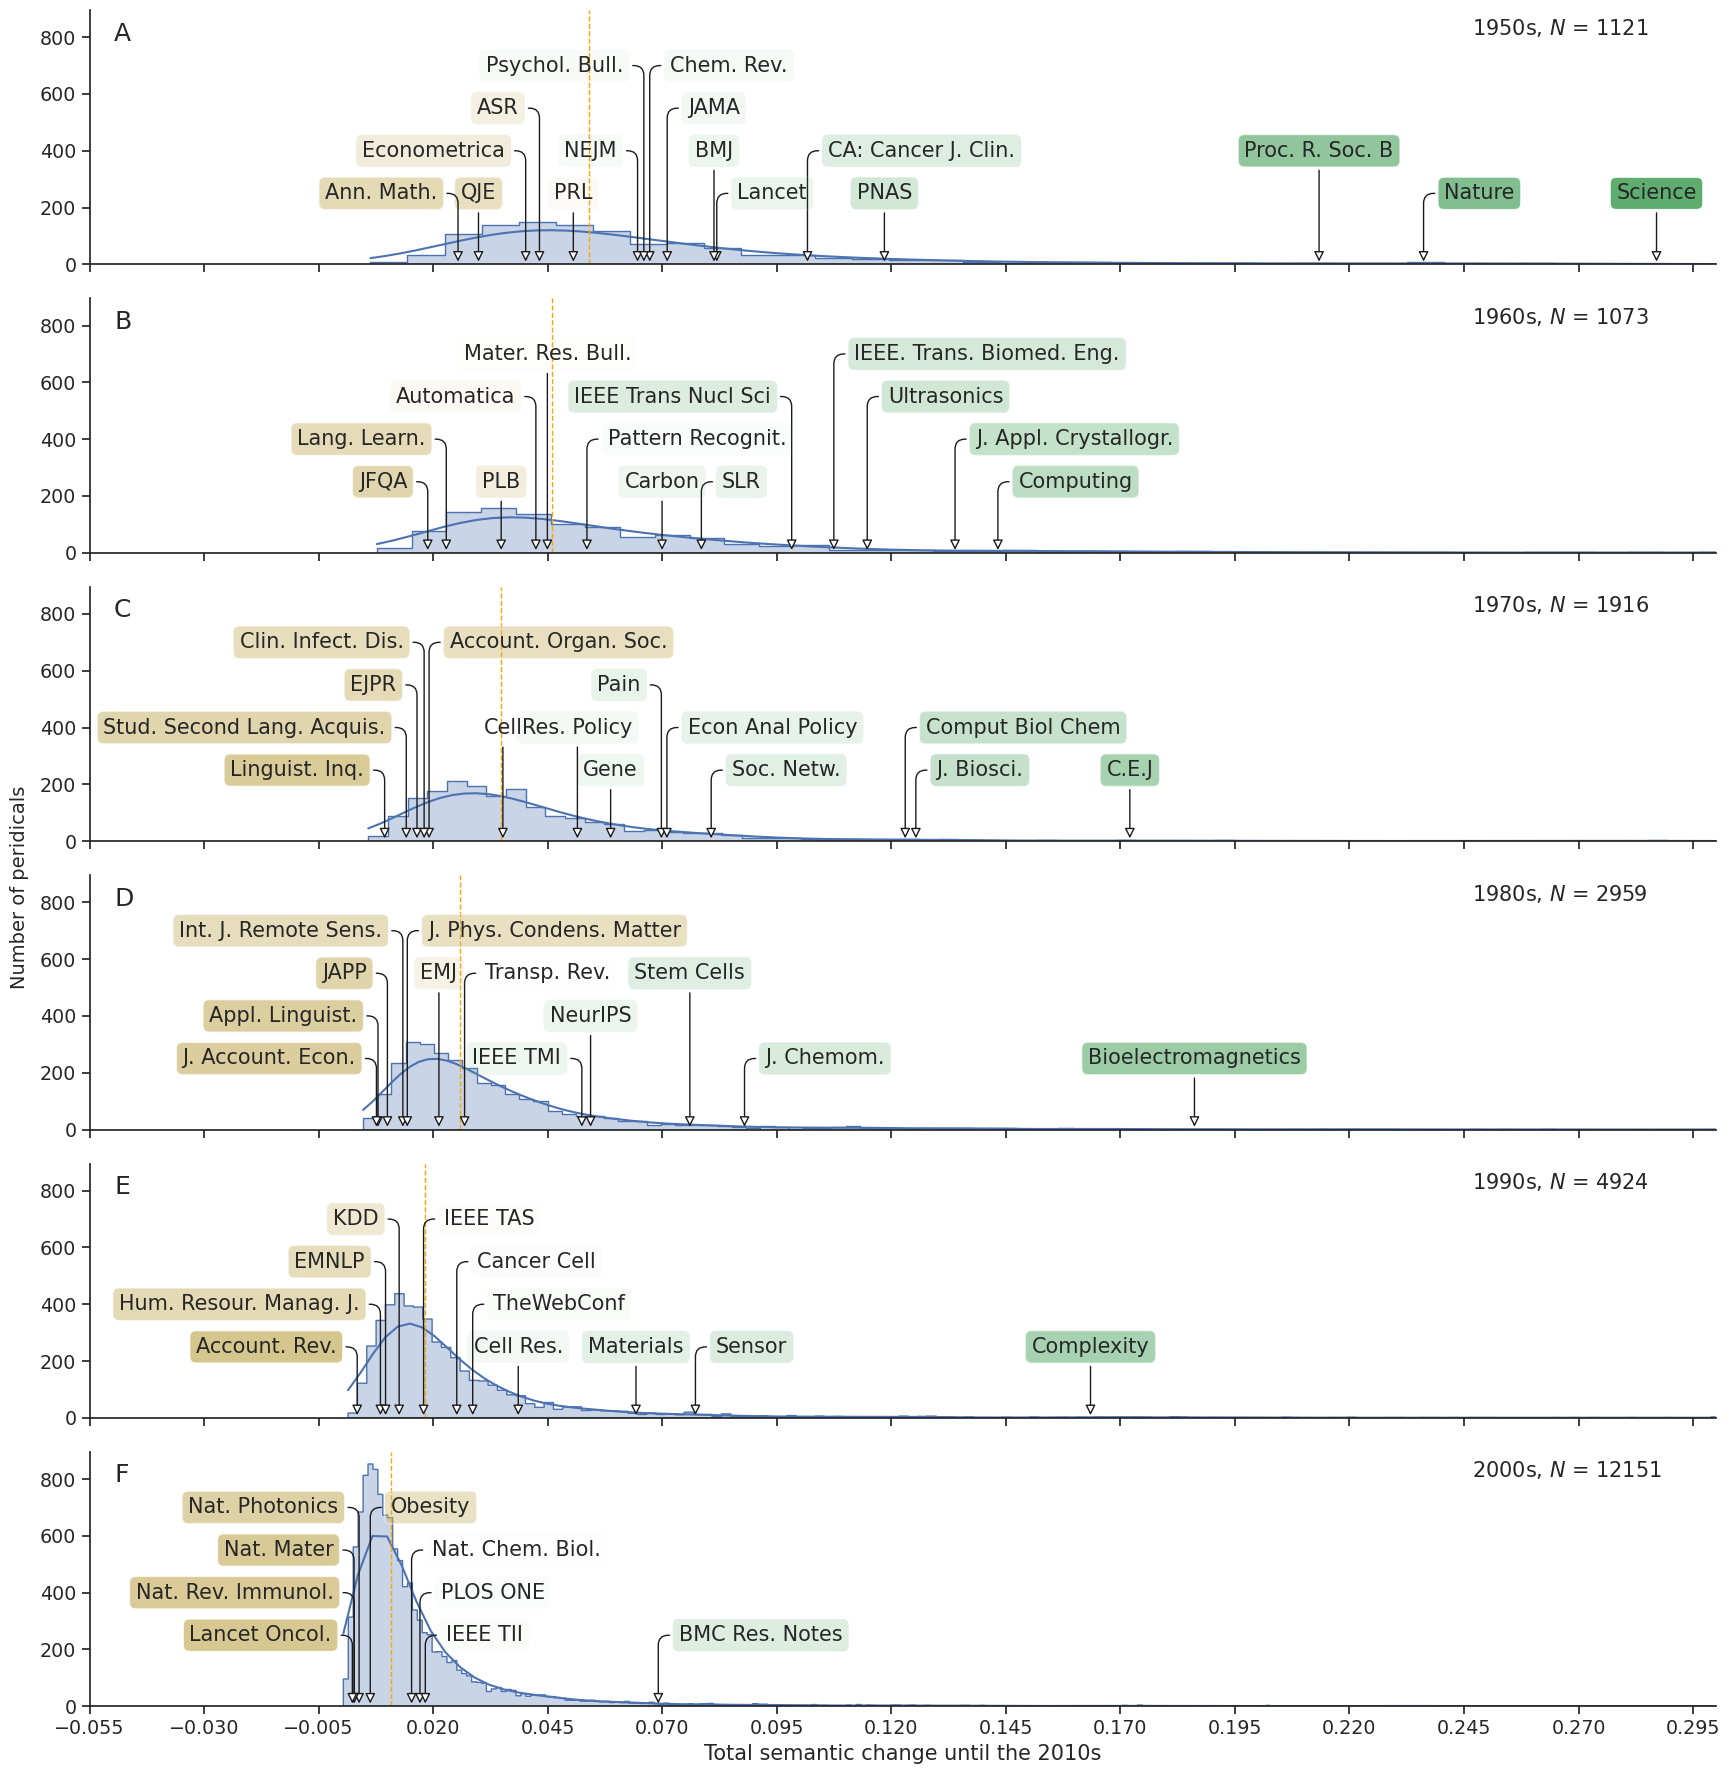

In [16]:
def annotate_n_and_decade(data, **kws):
    n = len(data)
    start_year = start_year_list[data.start_idx.unique()[0]]
    ax = plt.gca()
    ax.text(0.85, .9, f"{start_year}s, $N$ = {n}", transform=ax.transAxes)

def plot_median(x, **kwargs):
    ax = plt.gca()
    ax.axvline(x.median(), c='orange', ls='--', lw=1)

def annotate_periodical_name(data, opaque_value, **kwargs):
    selected_data = data[data.venue_name.isin(abbr_dict.keys())]
    display()
    ax = plt.gca()
    for index, row in selected_data.iterrows():
        TSC = row.total_semantic_change_2010s
        median = data.total_semantic_change_2010s.median()
        venue_name = row.venue_name

        if TSC <= median:
            c = 'y'
            alpha = (median - TSC) / median
        if TSC > median:
            c = 'g'
            alpha = (TSC - median) / (opaque_value - median)
        # ---------------------------adjust height---------------------------
        # low
        if venue_name in [# 1950s
                          'Science', 'Psychological Bulletin', 'Nature', 'Physical Review Letters', 
                          'Proceedings of the National Academy of Sciences of the United States of America', 
                          'The Lancet',
                          'Quarterly Journal of Economics', 'Annals of Mathematics', 
                          # 1960s
                          'Carbon', 'Stanford Law Review', 'Computing', 'Physics Letters B', 
                          'Journal of Financial and Quantitative Analysis',
                          'Atmosphere', 
                          # 1970s
                          'Linguistic Inquiry', 'Gene', 'Social Networks', 
                          'Civil Engineering', 'Journal of Biosciences',
                          # 1980s
                          'Journal of Chemometrics', 'Bioelectromagnetics',
                          'IEEE Transactions on Medical Imaging', 'Journal of Accounting and Economics', 
                          # 1990s
                          'The Accounting Review', 'Cell Research', 'Materials', 'Sensors', 'Complexity',
                          # 2000s
                          'Lancet Oncology', 'BMC Research Notes', 'IEEE Transactions on Industrial Informatics',
                         ]:
            label_y = 250
        # middle
        if venue_name in [# 1950s
                          'CA: A Cancer Journal for Clinicians', 'Econometrica', 'The New England Journal of Medicine', 
                          'Proceedings of The Royal Society B: Biological Sciences', 'BMJ',
                          # 1960s
                          'Language Learning', 'Journal of Applied Crystallography', 'Pattern Recognition', 
                          # 1970s
                          'Studies in Second Language Acquisition', 'Computational Biology and Chemistry', 'Cell', 'Research Policy',
                          'Economic Analysis and Policy', 
                          # 1980s
                          'neural information processing systems', 'Applied Linguistics', 
                          # 1990s
                          'Human Resource Management Journal', 'the web conference', 
                          # 2000s
                          'Nature Reviews Immunology', 'PLOS ONE', 
                          ]:
            label_y = 400
        # high
        if venue_name in [# 1950s
                          'JAMA', 'American Sociological Review', 
                          # 1960s
                          'Ultrasonics', 'Automatica', 'IEEE Transactions on Nuclear Science', 
                          # 1970s
                          'Life sciences in space research', 'European Journal of Political Research', 'Pain', 
                          # 1980s
                          'Journal of Accounting and Public Policy', 'Transport Reviews', 'Stem Cells',
                          'European Management Journal', 
                          # 1990s
                          'Cancer Cell', 'empirical methods in natural language processing',
                          # 2000s
                          'Nature Materials', 'Nature Chemical Biology',
                         ]:
            label_y = 550
        # ultra high
        if venue_name in [# 1950s
                          'Chemical Reviews', 'Psychological Bulletin', 
                          # 1960s
                          'IEEE Transactions on Biomedical Engineering', 'Materials Research Bulletin',
                          # 1970s
                          'Accounting Organizations and Society', 
                          'Clinical Infectious Diseases', 
                          # 1980s
                          'Journal of Physics: Condensed Matter', 'International Journal of Remote Sensing',
                          # 1990s
                          'knowledge discovery and data mining', 'IEEE Transactions on Applied Superconductivity',
                          # 2000s
                          'Nature Photonics', 'Obesity',
                          ]:
            label_y = 700
            
        # ---------------------------adjust arrow direction---------------------------
        # straight arrow
        if venue_name in [# 1950s
                          'Proceedings of the National Academy of Sciences of the United States of America',
                          'Quarterly Journal of Economics', 'BMJ', 'Physical Review Letters', 
                          'Proceedings of The Royal Society B: Biological Sciences', 'Science', 
                          # 1960s
                          'Carbon', 'Materials Research Bulletin', 'Physics Letters B', 
                          # 1970s
                          'Gene', 'Research Policy',
                          'Civil Engineering', 'Cell',
                          # 1980s
                          'Stem Cells', 'Bioelectromagnetics', 'European Management Journal', 
                          'neural information processing systems', 
                          # 1990s
                          'Complexity', 'Cell Research', 'Materials',
                         # 2000s

                         ]:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.", fc="w", color='k')
            label_x = TSC
            haligh = 'center'
            
        # bend arrow
        else:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="angle,angleA=0,angleB=-90,rad=10", fc="w", color='k')
            # bend right
            if venue_name in [# 1950s
                              'Proceedings of the National Academy of Sciences of the United States of America',
                              'The New England Journal of Medicine', 'CA: A Cancer Journal for Clinicians',
                              'Chemical Reviews', 'The Lancet', 'Nature', 'JAMA', 
                              # 1960s
                              'IEEE Transactions on Biomedical Engineering', 'Journal of Applied Crystallography', 
                              'Pattern Recognition', 'Computing', 'Ultrasonics', 
                              'Stanford Law Review', 
                              # 1970s
                              'Accounting Organizations and Society', 'Social Networks', 'Computational Biology and Chemistry', 
                              'Economic Analysis and Policy', 'Life sciences in space research', 'Journal of Biosciences', 
                              # 1980s
                              'Transport Reviews', 
                              'Journal of Chemometrics', 'Journal of Physics: Condensed Matter', 
                              # 1990s
                              'the web conference', 'Cancer Cell', 'Sensors', 'IEEE Transactions on Applied Superconductivity', 
                              # 2000s
                              'Obesity', 'Nature Chemical Biology', 'IEEE Transactions on Industrial Informatics', 'PLOS ONE', 
                              'BMC Research Notes',
                             ]:
                label_x = TSC + 0.0045
                haligh = 'left'
            # bend left
            if venue_name in [# 1950s
                              'Econometrica', 'Annals of Mathematics', 'Psychological Bulletin', 
                              'The New England Journal of Medicine', 'Journal of Financial and Quantitative Analysis', 
                              'American Sociological Review', 
                              # 1960s
                              'Atmosphere', 'IEEE Transactions on Nuclear Science', 'Automatica', 'Language Learning',
                              # 1970s
                              'Linguistic Inquiry', 'Studies in Second Language Acquisition', 
                              'European Journal of Political Research',
                              'Clinical Infectious Diseases', 'Pain', 
                              # 1980s
                              'Applied Linguistics', 'Journal of Accounting and Economics', 'IEEE Transactions on Medical Imaging',
                              'Journal of Accounting and Public Policy', 'International Journal of Remote Sensing',
                             # 1990s
                              'The Accounting Review', 'Human Resource Management Journal', 
                              'empirical methods in natural language processing', 'knowledge discovery and data mining', 
                             # 2000s
                              'Nature Reviews Immunology', 'Nature Materials', 'Lancet Oncology', 'Nature Photonics', 
                              
            ]: 
                label_x = TSC - 0.0045
                haligh = 'right'

        bbox_props = dict(boxstyle="round", fc=c, ec="1", alpha=alpha)
        ax.annotate(abbr_dict[venue_name], xy=(TSC, 0), xytext=(label_x, label_y), ha=haligh, va="center",
                    size=15, bbox = bbox_props, arrowprops = arrow_props)

plt.figure(dpi=300)
sns.set(style='white', font_scale=1.25)
g2 = sns.FacetGrid(local_semantic_change_df, 
                   row="start_idx", height=3, aspect=6, margin_titles=True)
g2.tick_params(axis='both', bottom='on',left='on')
g2.set(xlim=(-0.05, 0.3), xticks=np.arange(-0.055, 0.3, 0.025), yticks=np.arange(0, 1000, 200))

g2.map_dataframe(sns.histplot, x="total_semantic_change_2010s", kde=True, element='step', alpha=0.3)
g2.map(plot_median, 'total_semantic_change_2010s')
g2.map_dataframe(annotate_n_and_decade)
g2.map_dataframe(annotate_periodical_name, data=local_semantic_change_df, opaque_value=0.3)

panel_labels = ['A', 'B', 'C', 'D', 'E', 'F']
for i in range(g2.axes.flatten().shape[0]):
    ax = g2.axes.flatten()[i]
    ax.set_ylabel('')
    ax.text(0.015, .88, panel_labels[i], fontsize=18, transform=ax.transAxes)
    
g2.set_titles(row_template='')
g2.set_axis_labels('Total semantic change until the 2010s')
g2.fig.supylabel('Number of peridicals', x=0.01, fontsize=14)

plt.show()

In [17]:
g2.savefig('total_local_semantic_change_k_10.pdf', 
          dpi = 300, 
          facecolor='white', 
          transparent=False, 
          bbox_inches='tight')

# Aggregate total local semantic change into discipline level

In [18]:
discipline_abbr_dict = {'Business, Management and Accounting':	'Bus., MGMT & ACCT',
             'Decision Sciences': 'Decis.',
             'Arts and Humanities': 'Arts & HUMN',
             'Nursing': 'Nursing',
             'Pharmacology, Toxicology and Pharmaceutics': 'Pharm.',
             'Health Professions': 'Health Pro',
             'Computer Science': 'CS',
             'Medicine': 'Med.',
             'Environmental Science': 'Env.',
             'Dentistry': 'Dentistry',
             'Social Sciences': 'Soc.',
             'Engineering': 'Eng.',
             'Veterinary': 'Vet.',
             'Economics, Econometrics and Finance': 'Econ.',
             'Biochemistry, Genetics and Molecular Biology': 'Biochem.',
             'Energy': 'NRG',
             'Neuroscience': 'Neuro.',
             'Immunology and Microbiology': 'Immunol. & Microbiol.',
             'Agricultural and Biological Sciences': 'AG & Bio.',
             'Multidisciplinary': 'Multidiscip.',
             'Materials Science': 'Mat.',
             'Mathematics': 'Math',
             'Earth and Planetary Sciences': 'Earth',
             'Chemical Engineering': 'Chem. Eng.',
             'Psychology': 'Psy.',
             'Chemistry': 'Chem.',
             'Physics and Astronomy': 'Phy. & Astron.',
}

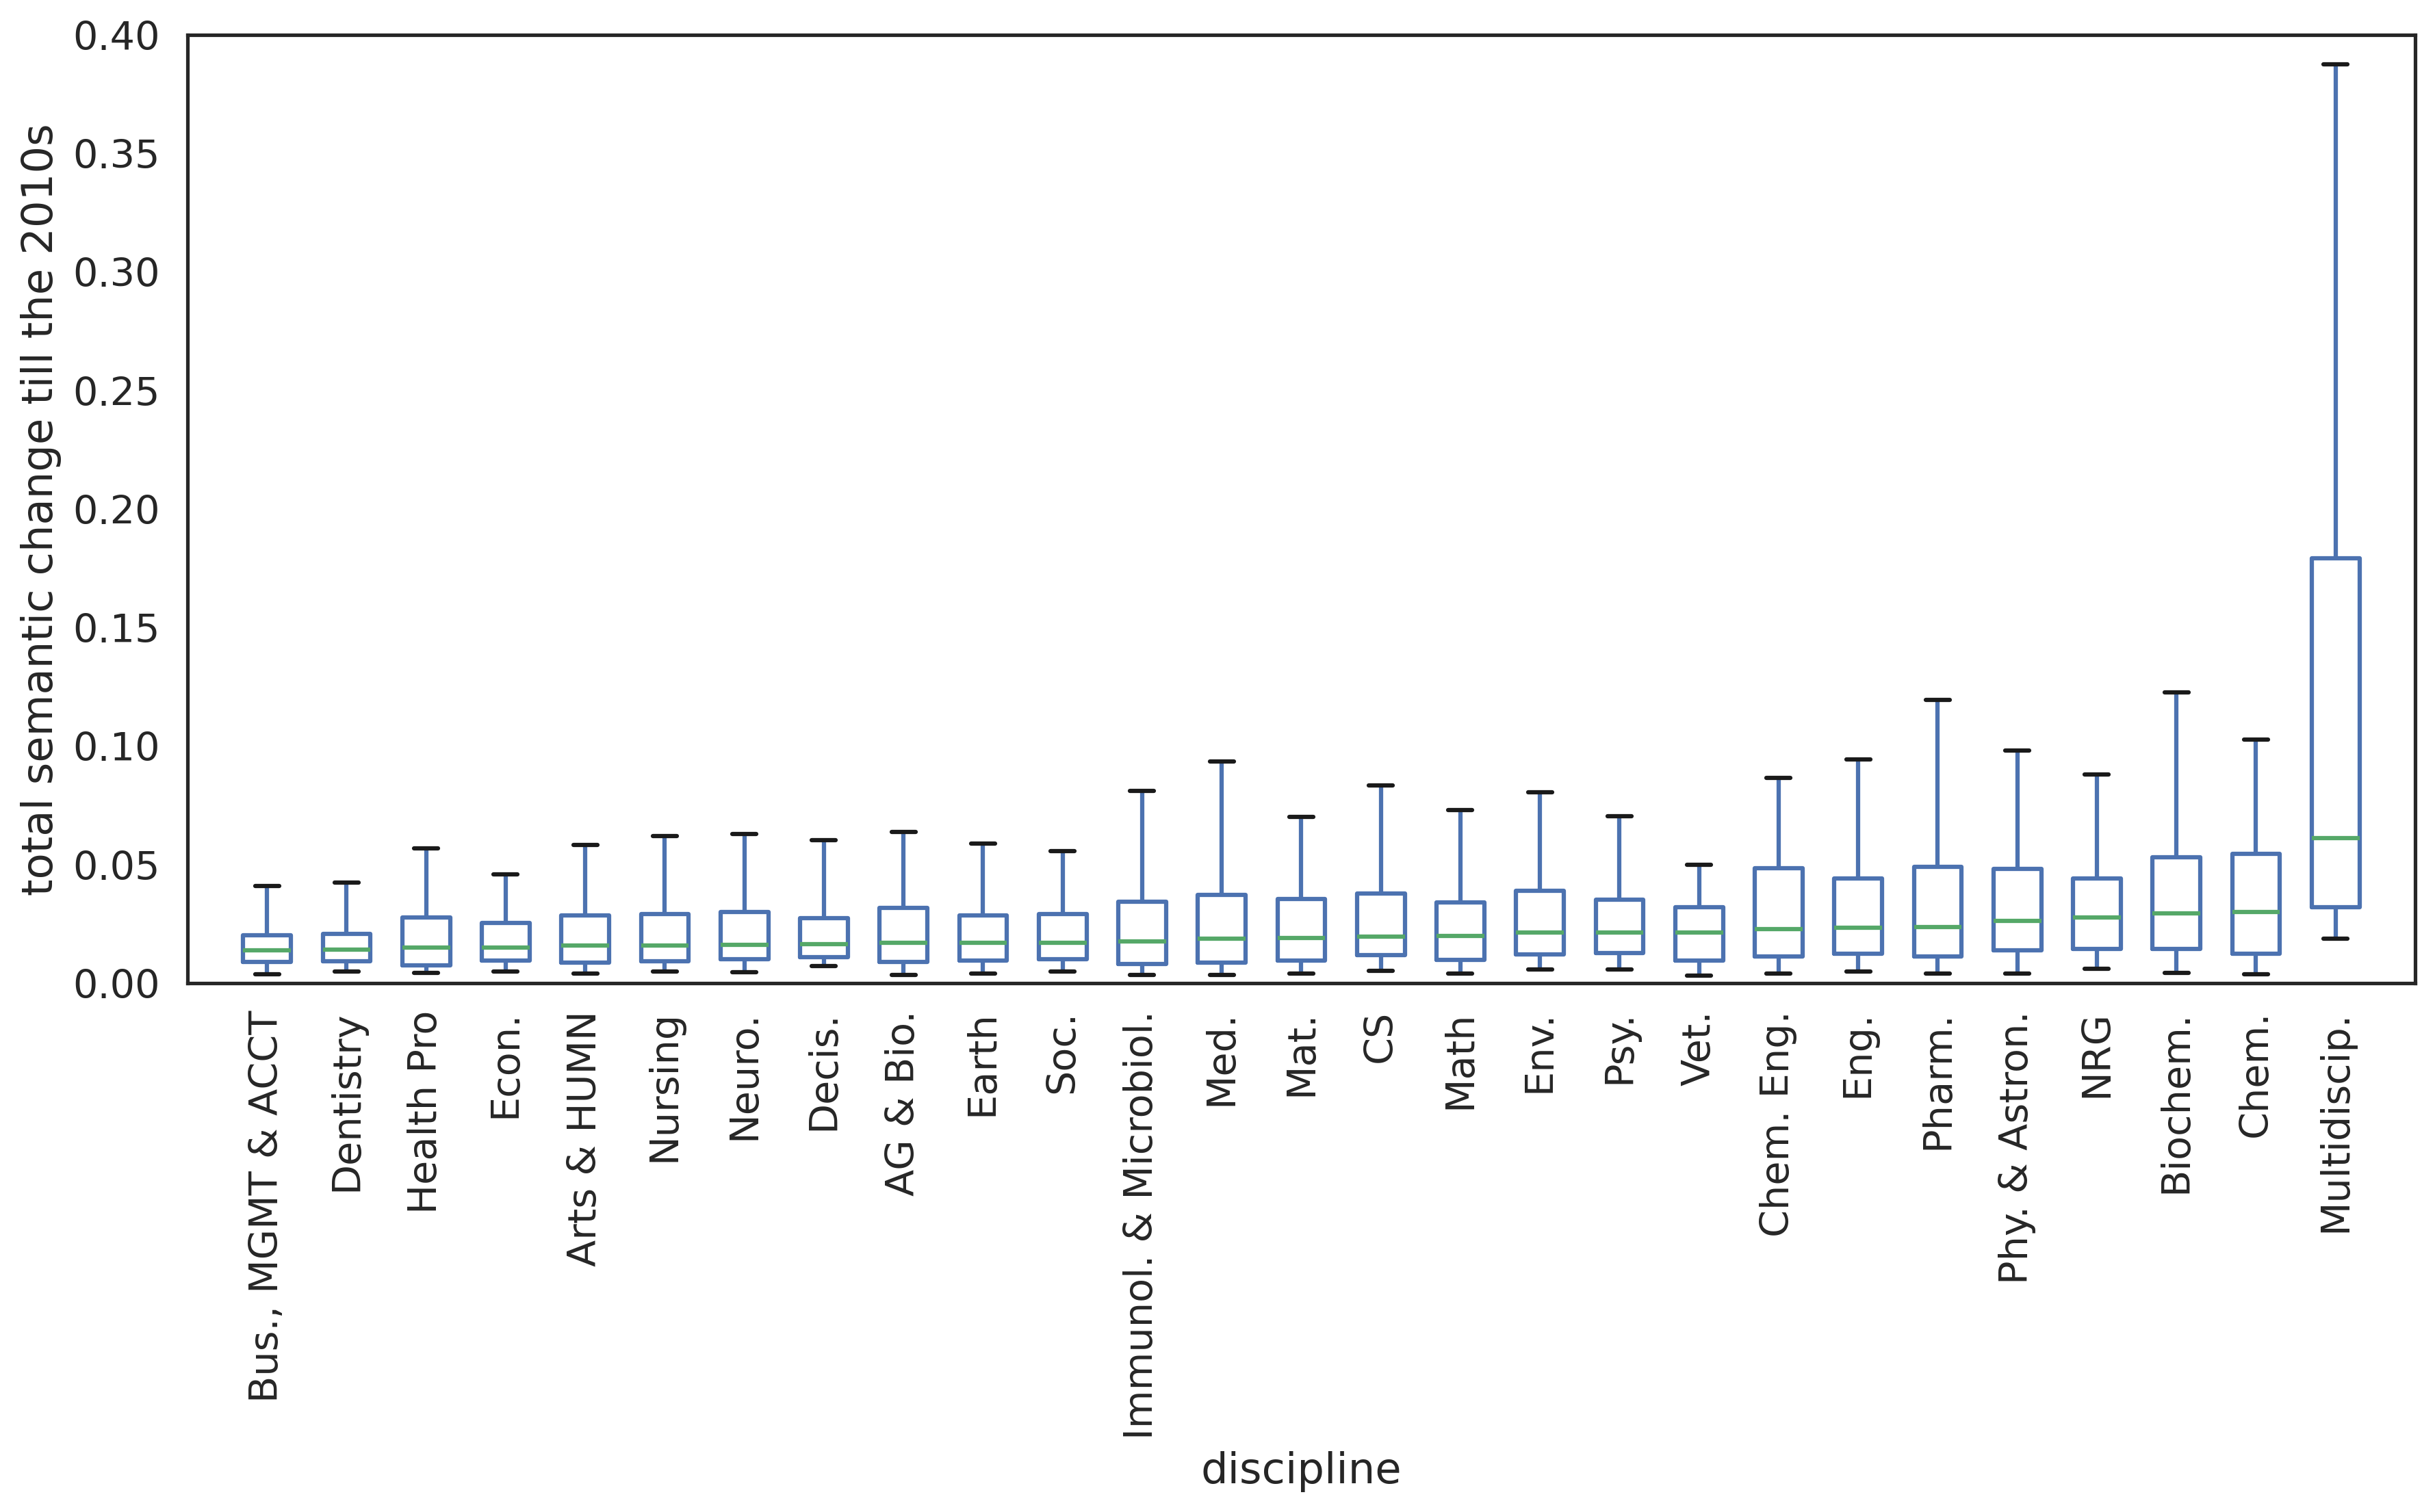

In [19]:
local_semantic_change_df_rename = local_semantic_change_df.copy()
local_semantic_change_df_rename.scopus_label = local_semantic_change_df_rename.scopus_label.replace(discipline_abbr_dict)
col_name = 'total_semantic_change_2010s'

plt.figure(figsize=(14,6), dpi=300)
plt.xticks(rotation=90)
g3 = sns.boxplot(x="scopus_label", y="total_semantic_change_2010s", data=local_semantic_change_df_rename, 
                 order=local_semantic_change_df_rename.groupby('scopus_label').agg({col_name:'median'}).sort_values(by=col_name).index.to_list(),
                 whis=(5,95), fliersize=0, fill=False, gap=0.25,
                 medianprops={'color': 'g'},
                 capprops={'color': 'k'},
                )
g3.set(xlabel='discipline',
       ylabel='total semantic change till the 2010s',
       ylim=(0.0, 0.4),
       xlim=(-1, len(discipline_abbr_dict))
      )
plt.show()

In [20]:
g3.get_figure().savefig('total_local_semantic_change_by_discipline_k_10.pdf', 
          dpi = 300, 
          facecolor='white', 
          transparent=False, 
          bbox_inches='tight')

# Bootstrap

### Generate data

In [7]:
import pandas as pd
from tqdm import tqdm

def pad_list_with_none(lst, target_length=6):
    print('padding length:', target_length - len(lst))
    padding = [None] * (target_length - len(lst))  # generate None list
    return padding + lst  # padding from left

def random_replace_per_row(df: pd.DataFrame, column_to_drop: str, remain_columns: list):
    col_to_drop_idx = df.columns.get_loc(column_to_drop)
    
    # generate a random column index for each row
    num_rows = len(df)
    random_columns_idx = np.random.randint(0, len(remain_columns), size=num_rows)
    
    # create a 1D array to store candicate values for each row
    replacement_values = np.array([df[remain_columns[col_idx]].values[i] for i, col_idx in enumerate(random_columns_idx)])
    df.iloc[:, col_to_drop_idx] = replacement_values
    return df

start_idxs = [0, 1, 2, 3, 4]
period_list = ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 
               'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
n_iter = 1000
all_age_group_result_df = pd.DataFrame(columns=['founded decade', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s'])

for start_idx in start_idxs:
    print(f'processing {start_year_list[start_idx]}s')
    sampling_df = local_semantic_change_df[local_semantic_change_df.start_idx==start_idx].copy()
    sampling_df.drop(columns=['total_semantic_change_1960s', 'total_semantic_change_1970s', 'total_semantic_change_1980s',
                              'total_semantic_change_1990s', 'total_semantic_change_2000s', 'total_semantic_change_2010s'], inplace=True)
    median_original = local_semantic_change_df[local_semantic_change_df.start_idx==start_idx].total_semantic_change_2010s.median()
    all_period_median_list = []
    if start_idx == 0: # store the avg of bootstrapping distributions for periodicals established in the 1950s
        all_period_mean_list = []

    for period in period_list[start_idx:]:
        print('period to drop:', period)
        column_to_drop = period
        change_df = sampling_df.copy()

        remain_columns = period_list.copy()
        remain_columns.remove(period)
        print('remain columns:', remain_columns)

        bootstrap_results = np.zeros((n_iter, len(change_df)))  # pre allocate memory

        print('start iterating...')
        for i in tqdm(range(n_iter), desc='Iterations'):
            replaced_df = random_replace_per_row(change_df.copy(), column_to_drop, remain_columns) # make replacement for each row
            bootstrap_results[i, :] = replaced_df[period_list].sum(axis=1).values

        # median of all periodials, shape: (n_iter, n_periodicals)
        bootstrap_medians = np.median(bootstrap_results, axis=1)
        bootstrap_medians_diff = (median_original - bootstrap_medians)/median_original # shape: (n_iter,)
        all_period_median_list.append(bootstrap_medians_diff)

        if start_idx == 0: # only do this for periodicals established in the 1950s
            # store the average of all bootstrap sample, shape: (n_periodicals,), to plot 6 subplots on the left
            all_period_mean_list.append(np.mean(bootstrap_results, axis=0)) 
            
    print('length of generate data:', len(all_period_median_list))
    all_period_median_list = pad_list_with_none(all_period_median_list)

    # creat a new row and add the new row to the DataFrame
    new_row = pd.DataFrame({
        'founded decade': [str(start_year_list[start_idx])+'s'],
        '1960s': [all_period_median_list[0]],
        '1970s': [all_period_median_list[1]],
        '1980s': [all_period_median_list[2]],
        '1990s': [all_period_median_list[3]],
        '2000s': [all_period_median_list[4]],
        '2010s': [all_period_median_list[5]]
    })
    all_age_group_result_df = pd.concat([all_age_group_result_df, new_row], ignore_index=True)
    print('\n')

processing 1950s
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 381.62it/s]


period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 384.67it/s]


period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 385.63it/s]


period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 385.65it/s]


period to drop: semantic_change_2000s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 385.20it/s]


period to drop: semantic_change_2010s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 383.44it/s]


length of generate data: 6
padding length: 0


processing 1960s
period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 399.07it/s]


period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 397.08it/s]


period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 388.46it/s]


period to drop: semantic_change_2000s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 395.25it/s]


period to drop: semantic_change_2010s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 397.71it/s]


length of generate data: 5
padding length: 1


processing 1970s
period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:04<00:00, 242.69it/s]


period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:04<00:00, 242.79it/s]


period to drop: semantic_change_2000s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:04<00:00, 241.31it/s]


period to drop: semantic_change_2010s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:04<00:00, 241.18it/s]


length of generate data: 4
padding length: 2


processing 1980s
period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:06<00:00, 161.14it/s]


period to drop: semantic_change_2000s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:06<00:00, 164.02it/s]


period to drop: semantic_change_2010s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:06<00:00, 162.02it/s]


length of generate data: 3
padding length: 3


processing 1990s
period to drop: semantic_change_2000s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:09<00:00, 101.67it/s]


period to drop: semantic_change_2010s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:09<00:00, 101.30it/s]

length of generate data: 2
padding length: 4




### Plot Separately

Number of periodicals: 1121


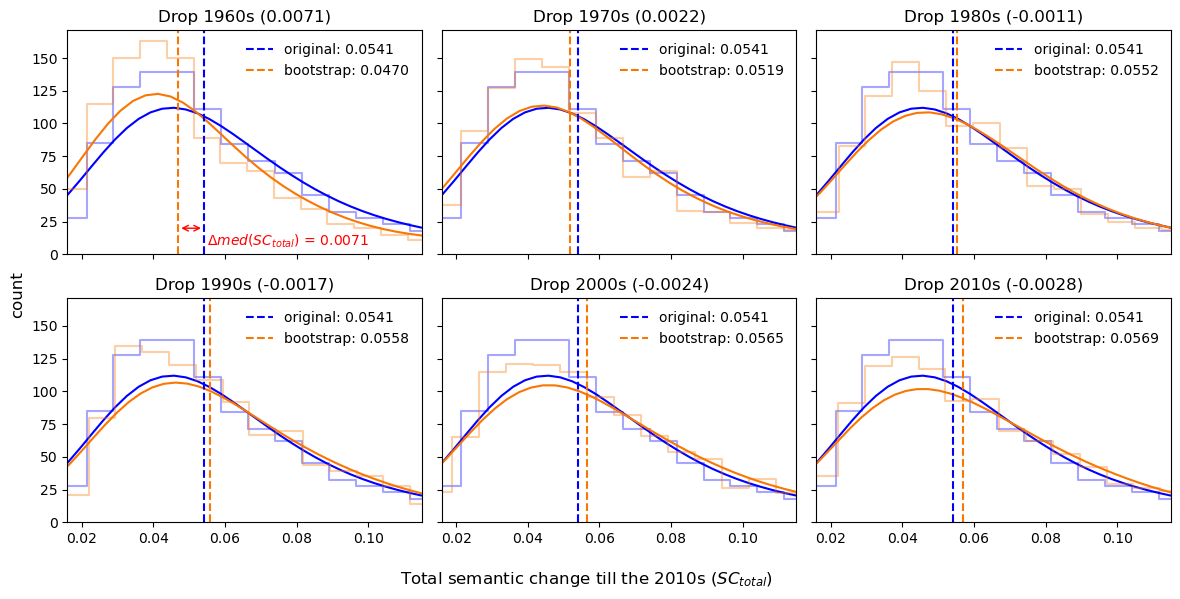

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
start_idx = 0

# plot distributions period by period
for i, data in enumerate(all_period_mean_list):
    row, col = divmod(i, 3) # calculate row and column index

    sns.histplot(local_semantic_change_df[local_semantic_change_df.start_idx==start_idx].total_semantic_change_2010s, 
                 kde=True, ax=axes[row][col], binwidth=0.0075, alpha=0.35, element="step", color='blue', fill=False)
    sns.histplot(data, kde=True, ax=axes[row][col], binwidth=0.0075, alpha=0.35, element="step", color='#fa7602', fill=False)

    # indicate median value in the histogram
    median_original = local_semantic_change_df[local_semantic_change_df.start_idx==start_idx].total_semantic_change_2010s.median()
    median = np.median(data) 
    axes[row][col].axvline(median_original, color='blue', linestyle='--', label=f'original: {median_original:.4f}')
    axes[row][col].axvline(median, color='#fa7602', linestyle='--', label=f'bootstrap: {median:.4f}') 

    median_diff = median_original - median
    if median_diff > 0.005:
        axes[row][col].annotate('', xy=(median, 20), xytext=(median_original, 20), 
                     arrowprops=dict(arrowstyle="<->", color='red', lw=1))
        axes[row][col].text((median+median_original)/2+0.027, 10, f'$\Delta med(SC_{{total}})$ = {median_diff:.4f}', color='red', ha='center', va='center')
    
    axes[row][col].set_xlim(0.016, 0.115)

    axes[row][col].set_title(f'Drop {period_list[i][-5:]} ({median_diff:.4f})')
    axes[row][col].set_xlabel('')
    axes[row][col].set_ylabel('')
    axes[row][col].legend(frameon=False)

print('Number of periodicals:', len(local_semantic_change_df[local_semantic_change_df.start_idx==start_idx]))

fig.supxlabel('Total semantic change till the 2010s ($SC_{total}$)')
fig.supylabel('count')

plt.tight_layout()
plt.show()

C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_11388\3627019744.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, temp_df], ignore_index=True)
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_11388\3627019744.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks_v)


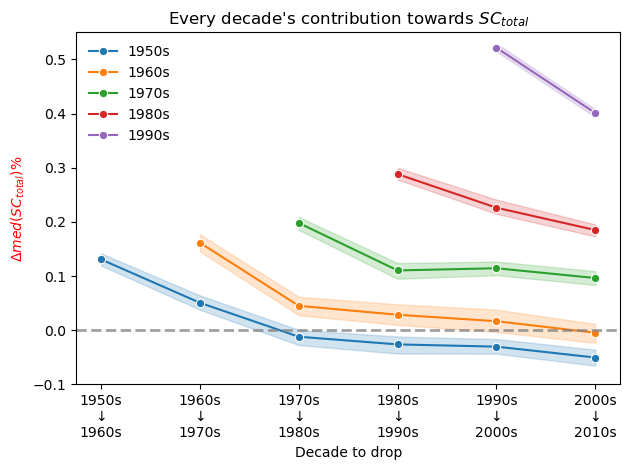

In [22]:
import pandas as pd
plot_data = pd.DataFrame(columns=['Decade', 'Value', 'founded decade'])

for decade in ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']:
    for idx, founded_decade in enumerate(all_age_group_result_df['founded decade']):
        if all_age_group_result_df[decade][idx] is not None:
            temp_df = pd.DataFrame({
                'Decade': [decade] * len(all_age_group_result_df[decade][idx]),
                'Value': all_age_group_result_df[decade][idx].flatten(),
                'founded decade': [founded_decade] * len(all_age_group_result_df[decade][idx])
            })
        plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

plt.figure()
ax = plt.gca()
sns.lineplot(data=plot_data, x='Decade', y='Value', hue='founded decade', errorbar='pi', marker='o')

xticks_v = ['1950s\n↓\n1960s', '1960s\n↓\n1970s','1970s\n↓\n1980s','1980s\n↓\n1990s','1990s\n↓\n2000s','2000s\n↓\n2010s']
ax.set_xticklabels(xticks_v)
ax.axhline(0, color='grey', alpha=0.75, linestyle='--', lw=2)

plt.title('Every decade\'s contribution towards $SC_{total}$')
plt.xlabel('Decade to drop')
plt.ylabel('$\Delta med(SC_{total})\%$', color='red')
ax.set_ylim(-0.1, 0.55)
plt.legend(frameon=False)
plt.tight_layout()

plt.show()

### Plot togather

C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_22008\358451821.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, temp_df], ignore_index=True)
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_22008\358451821.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(xticks_v)


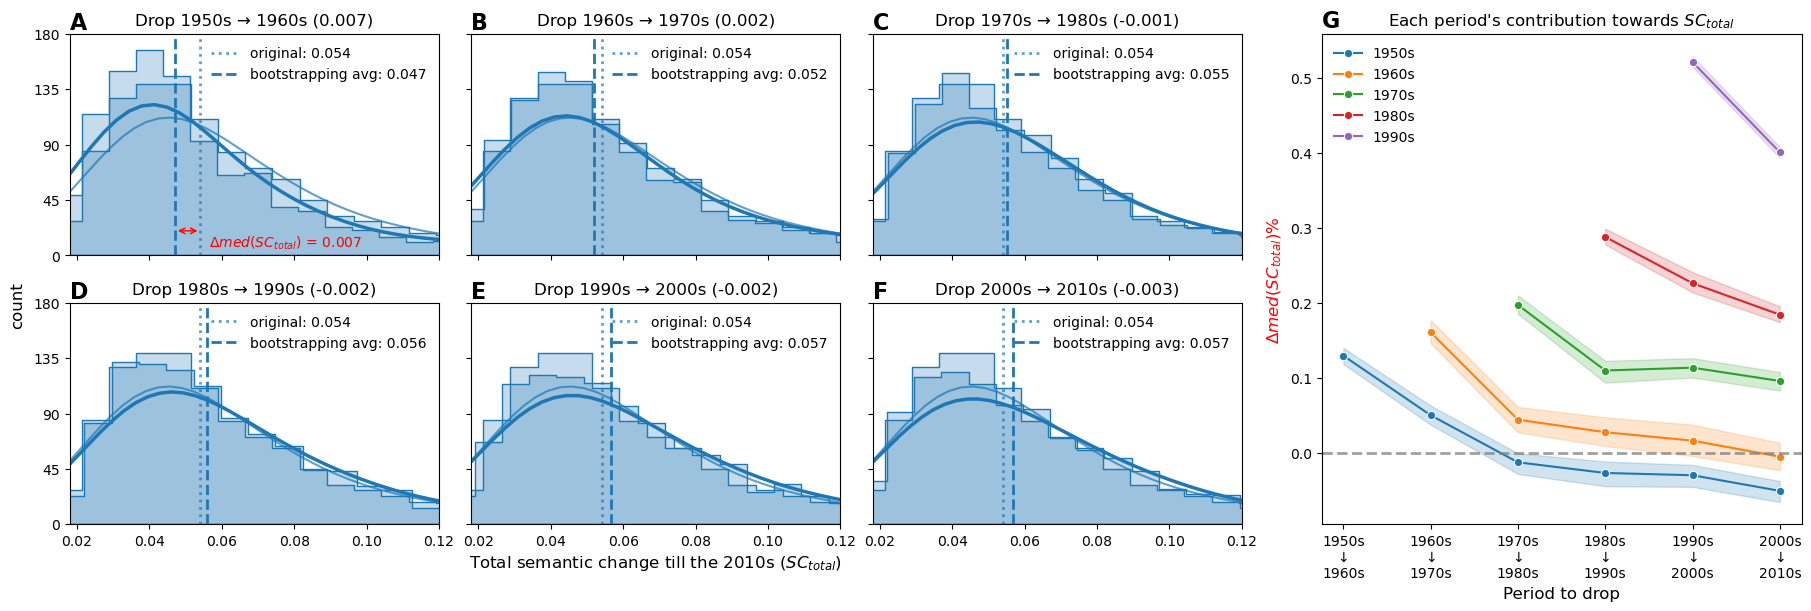

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# creat a figure with 2 rows and 4 columns, the first 3 columns for the first plot, the last column for the second plot
fig1 = plt.figure(figsize=(18, 6), constrained_layout=True)
grid = fig1.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1.3], hspace=0.01, wspace=0.01)  # more space for the second plot

# manully set the y-axis range and ticks
y_min, y_max = 0, 180
yticks = np.linspace(y_min, y_max, 5)

xticks_v = ['1950s\n↓\n1960s', '1960s\n↓\n1970s','1970s\n↓\n1980s','1980s\n↓\n1990s','1990s\n↓\n2000s','2000s\n↓\n2010s']
title_period = ['1950s → 1960s', '1960s → 1970s','1970s → 1980s','1980s → 1990s','1990s → 2000s','2000s → 2010s']

# axes of the first plot
axes = []
panel_labels = ['A', 'B', 'C', 'D', 'E', 'F']  # Define panel labels
for row in range(2):
    for col in range(3):
        ax = fig1.add_subplot(grid[row, col])
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(yticks)
        axes.append(ax)

# the first plot: plot distributions period by period
start_idx = 0
for i, data in enumerate(all_period_mean_list):
    row, col = divmod(i, 3)  # calculate row and column index

    ax = axes[i]
    sns.histplot(local_semantic_change_df[local_semantic_change_df.start_idx == start_idx].total_semantic_change_2010s,
                 kde=True, ax=ax, binwidth=0.0075, alpha=0.25, line_kws={'alpha': 0.7}, element="step", color='#1f77b4', fill=True)
    sns.histplot(data, kde=True, ax=ax, binwidth=0.0075, alpha=0.25, line_kws={'lw': 2.5}, element="step", color='#1f77b4', fill=True)

    # indicate median value in the histogram
    median_original = local_semantic_change_df[local_semantic_change_df.start_idx == start_idx].total_semantic_change_2010s.median()
    median = np.median(data)
    ax.axvline(median_original, color='#1f77b4', alpha=0.7, linestyle='dotted', lw=2, label=f'original: {median_original:.3f}')
    ax.axvline(median, color='#1f77b4', linestyle='--', lw=2, label=f'bootstrapping avg: {median:.3f}')

    median_diff = median_original - median
    if median_diff > 0.005:
        ax.annotate('', xy=(median, 20), xytext=(median_original, 20),
                    arrowprops=dict(arrowstyle="<->", color='red', lw=1))
        ax.text((median + median_original) / 2 + 0.027, 10, f'$\Delta med(SC_{{total}})$ = {median_diff:.3f}', color='red', ha='center', va='center')

    # adjust axis labels and ticklabels
    ax.set_ylabel('')
    if row == 1 and col == 1:
        ax.set_xlabel('Total semantic change till the 2010s ($SC_{total}$)', fontsize='larger')
    else:
        ax.set_xlabel('')
    if row != 1:
        ax.set_xticklabels([])
    if col != 0:
        ax.set_yticklabels([])
    
    ax.set_xlim(0.018, 0.12)
    ax.set_title(f'Drop {title_period[i]} ({median_diff:.3f})')
    ax.legend(frameon=False)

    # Add panel label in the top-left corner of each subplot
    ax.text(-0.0, 1.1, panel_labels[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

# create a super title for the first plot
fig1.supylabel('count')

# the second plot: plot line chart
ax2 = fig1.add_subplot(grid[:, 3])  # the second plot taks the whole last column

plot_data = pd.DataFrame(columns=['Decade', 'Value', 'founded decade'])
for decade in ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']:
    for idx, founded_decade in enumerate(all_age_group_result_df['founded decade']):
        if all_age_group_result_df[decade][idx] is not None:
            temp_df = pd.DataFrame({
                'Decade': [decade] * len(all_age_group_result_df[decade][idx]),
                'Value': all_age_group_result_df[decade][idx].flatten(),
                'founded decade': [founded_decade] * len(all_age_group_result_df[decade][idx])
            })
            plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

sns.lineplot(data=plot_data, x='Decade', y='Value', hue='founded decade', errorbar='pi', marker='o', ax=ax2)
ax2.axhline(0, color='grey', alpha=0.75, linestyle='--', lw=2)

ax2.set_title('Each period\'s contribution towards $SC_{total}$')
ax2.set_xlabel('Period to drop', fontsize='larger')
ax2.set_xticklabels(xticks_v)
ax2.set_ylabel('$\Delta med(SC_{total})\%$', color='red', fontsize='larger')
ax2.legend(frameon=False)

# Add panel label for the second plot
ax2.text(-0.0, 1.05, 'G', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

plt.show()

In [14]:
fig1.savefig('bootstrap.pdf', 
              facecolor='white', 
              transparent=False, 
              bbox_inches='tight')

### If don't bootstraping...

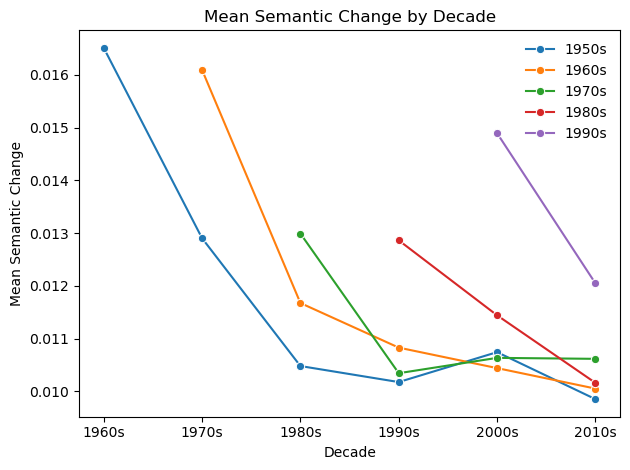

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

decades = ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
plt.figure()

for idx in range(5):
    mean_values = local_semantic_change_df[local_semantic_change_df.start_idx == idx][[
        'semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s',
        'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s'
    ]].mean()
    plot_data = pd.DataFrame({
        'Decade': decades,
        'Mean Semantic Change': mean_values
    })
    sns.lineplot(data=plot_data, x='Decade', y='Mean Semantic Change', marker='o', label=f'{start_year_list[idx]}s')

plt.title('Mean Semantic Change by Decade')
plt.legend(frameon=False)
plt.tight_layout()

plt.show()

### If we truncate some points from the oldest periodicals (established in the 1950s)...

#### Truncate from left:

In [44]:
import pandas as pd
from tqdm import tqdm

def pad_list_with_none(lst, target_length=6):
    print('padding length:', target_length - len(lst))
    padding = [None] * (target_length - len(lst))  # generate None list
    return padding + lst  # padding from left

def random_replace_per_row(df: pd.DataFrame, column_to_drop: str, remain_columns: list):
    # 提前获取需要替换的列索引
    col_to_drop_idx = df.columns.get_loc(column_to_drop)
    
    # 使用 numpy 生成每一行的随机列索引
    num_rows = len(df)
    random_columns_idx = np.random.randint(0, len(remain_columns), size=num_rows)
    
    # create a 1D array to store candicate values for each row
    replacement_values = np.array([df[remain_columns[col_idx]].values[i] for i, col_idx in enumerate(random_columns_idx)])
    
    # 用替换后的数组进行替换
    df.iloc[:, col_to_drop_idx] = replacement_values
    return df

start_idx = 0

period_list = ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 
               'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
n_iter = 1000
all_age_group_result_df = pd.DataFrame(columns=['founded decade', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s'])
sampling_df = local_semantic_change_df[local_semantic_change_df.start_idx==start_idx].copy()
sampling_df.drop(columns=['total_semantic_change_2010s'], inplace=True)

# for peiodicals established in the 1950s, we cut periods they experienced into 2 parts:
# 1. kept_period_list
# 2. truncated_period_list
# the motivation is to see the impact from the number of points

for i in range(0, 5): # each truncation generates a new "simulated age group"
    print('truncate at:', i)
    kept_period_list = period_list[i:]
    truncated_period_list = period_list[:i]
    sampling_df[truncated_period_list] = np.nan

    median_original = sampling_df[period_list[i:]].sum(axis=1).median()
    all_period_median_list = []

    for period in kept_period_list:
        print('period to drop:', period)
        column_to_drop = period
        change_df = sampling_df.copy()

        remain_columns = kept_period_list.copy()
        remain_columns.remove(period)
        print('remain columns:', remain_columns)

        bootstrap_results = np.zeros((n_iter, len(change_df)))  # 提前分配内存

        print('start iterating...')
        for j in tqdm(range(n_iter), desc='Iterations'):
            # 每行随机替换
            replaced_df = random_replace_per_row(change_df.copy(), column_to_drop, remain_columns)
            bootstrap_results[j, :] = replaced_df[period_list].sum(axis=1).values  # 向量化操作

        # median of all periodials, shape: (n_iter, n_periodicals)
        bootstrap_medians = np.median(bootstrap_results, axis=1)
        bootstrap_medians_diff = median_original - bootstrap_medians # shape: (n_iter,)
        all_period_median_list.append(bootstrap_medians_diff)
            
    print('length of generate data:', len(all_period_median_list))
    all_period_median_list = pad_list_with_none(all_period_median_list)

    # creat a new row and add the new row to the DataFrame
    new_row = pd.DataFrame({
        'founded decade': '1950s_'+str(i),
        '1960s': [all_period_median_list[0]],
        '1970s': [all_period_median_list[1]],
        '1980s': [all_period_median_list[2]],
        '1990s': [all_period_median_list[3]],
        '2000s': [all_period_median_list[4]],
        '2010s': [all_period_median_list[5]]
    })
    all_age_group_result_df = pd.concat([all_age_group_result_df, new_row], ignore_index=True)

truncate at: 0
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 363.50it/s]


period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 371.17it/s]


period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 375.30it/s]


period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 375.45it/s]


period to drop: semantic_change_2000s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 374.01it/s]


period to drop: semantic_change_2010s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 373.47it/s]


length of generate data: 6
padding length: 0
truncate at: 1
period to drop: semantic_change_1970s
remain columns: ['semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 335.13it/s]


period to drop: semantic_change_1980s
remain columns: ['semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:03<00:00, 333.30it/s]


period to drop: semantic_change_1990s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 337.65it/s]


period to drop: semantic_change_2000s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:03<00:00, 330.53it/s]


period to drop: semantic_change_2010s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:03<00:00, 332.42it/s]


length of generate data: 5
padding length: 1
truncate at: 2
period to drop: semantic_change_1980s
remain columns: ['semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 338.73it/s]


period to drop: semantic_change_1990s
remain columns: ['semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 340.29it/s]


period to drop: semantic_change_2000s
remain columns: ['semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 336.00it/s]


period to drop: semantic_change_2010s
remain columns: ['semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 335.86it/s]


length of generate data: 4
padding length: 2
truncate at: 3
period to drop: semantic_change_1990s
remain columns: ['semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 342.83it/s]


period to drop: semantic_change_2000s
remain columns: ['semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 339.02it/s]


period to drop: semantic_change_2010s
remain columns: ['semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 339.97it/s]


length of generate data: 3
padding length: 3
truncate at: 4
period to drop: semantic_change_2000s
remain columns: ['semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 343.89it/s]


period to drop: semantic_change_2010s
remain columns: ['semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 341.94it/s]

length of generate data: 2
padding length: 4


C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_25524\3233345649.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, temp_df], ignore_index=True)


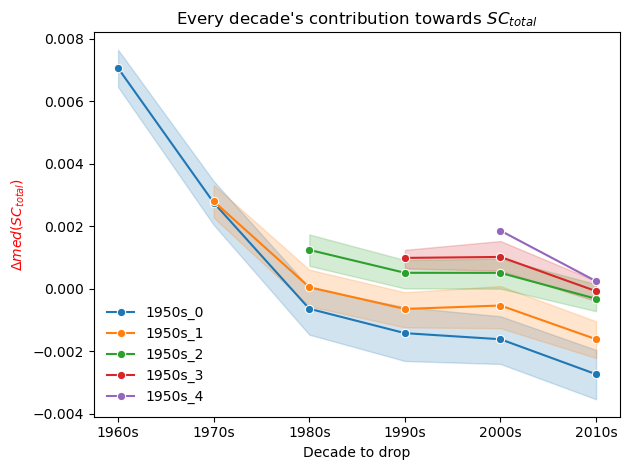

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 初始化plot_data DataFrame，确保变量已定义
plot_data = pd.DataFrame(columns=['Decade', 'Value', 'founded decade'])

# 循环处理每个时期的数据
for idx, founded_decade in enumerate(all_age_group_result_df['founded decade']):
    for decade in ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']:
        if all_age_group_result_df[decade][idx] is not None:
            temp_df = pd.DataFrame({
                'Decade': [decade] * len(all_age_group_result_df[decade][idx]),
                'Value': all_age_group_result_df[decade][idx].flatten(),
                'founded decade': [founded_decade] * len(all_age_group_result_df[decade][idx])
            })
            # 合并数据
            plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

# 绘图
plt.figure()
sns.lineplot(data=plot_data, x='Decade', y='Value', hue='founded decade', errorbar='pi', marker='o')

plt.title("Every decade's contribution towards $SC_{total}$")
plt.xlabel('Decade to drop')
plt.ylabel('$\Delta med(SC_{total})$', color='red')
plt.legend(frameon=False, loc='lower left')
plt.tight_layout()
plt.show()

#### truncate from the right:

In [19]:
import pandas as pd
from tqdm import tqdm

def pad_list_with_none(lst, target_length=6):
    print('padding length:', target_length - len(lst))
    padding = [None] * (target_length - len(lst))  # generate None list
    return lst + padding  # padding from right

def random_replace_per_row(df: pd.DataFrame, column_to_drop: str, remain_columns: list):
    col_to_drop_idx = df.columns.get_loc(column_to_drop)
    
    # generate a random column index for each row
    num_rows = len(df)
    random_columns_idx = np.random.randint(0, len(remain_columns), size=num_rows)
    
    # create a 1D array to store candicate values for each row
    replacement_values = np.array([df[remain_columns[col_idx]].values[i] for i, col_idx in enumerate(random_columns_idx)])
    df.iloc[:, col_to_drop_idx] = replacement_values
    return df

start_idx = 0
period_list = ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 
               'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
n_iter = 1000
all_age_group_result_df = pd.DataFrame(columns=['founded decade', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s'])
sampling_df = local_semantic_change_df[local_semantic_change_df.start_idx==start_idx].copy()
sampling_df.drop(columns=['total_semantic_change_2010s'], inplace=True)

# for peiodicals established in the 1950s, we cut periods they experienced into 2 parts:
# 1. kept_period_list
# 2. truncated_period_list
# the motivation is to see the impact from the number of points

for i in range(1, 6): # each truncation generates a new "simulated age group"
    print('truncate at:', i)
    kept_period_list = period_list[:i+1]
    truncated_period_list = period_list[i+1:]
    print('kept period:', kept_period_list)
    print('truncated period:', truncated_period_list)

    median_original = sampling_df[kept_period_list].sum(axis=1).median()
    print('original median:', median_original)
    all_period_median_list = []

    for period in kept_period_list:
        print('period to drop:', period)
        column_to_drop = period
        change_df = sampling_df.copy()

        remain_columns = kept_period_list.copy()
        remain_columns.remove(period)
        print('remain columns:', remain_columns)

        bootstrap_results = np.zeros((n_iter, len(change_df)))  # pre allocate memory

        print('start iterating...')
        for j in tqdm(range(n_iter), desc='Iterations'):
            replaced_df = random_replace_per_row(change_df.copy(), column_to_drop, remain_columns) # make replacement for each row
            bootstrap_results[j, :] = replaced_df[kept_period_list].sum(axis=1).values

        # median of all periodials, shape: (n_iter, n_periodicals)
        bootstrap_medians = np.median(bootstrap_results, axis=1)
        bootstrap_medians_diff = (median_original - bootstrap_medians)/median_original # shape: (n_iter,)
        all_period_median_list.append(bootstrap_medians_diff)
            
    print('length of generate data:', len(all_period_median_list))
    all_period_median_list = pad_list_with_none(all_period_median_list)

    # creat a new row and add the new row to the DataFrame
    new_row = pd.DataFrame({
        'founded decade': 'Keep the first '+str(i+1)+' periods',
        '1960s': [all_period_median_list[0]],
        '1970s': [all_period_median_list[1]],
        '1980s': [all_period_median_list[2]],
        '1990s': [all_period_median_list[3]],
        '2000s': [all_period_median_list[4]],
        '2010s': [all_period_median_list[5]]
    })
    all_age_group_result_df = pd.concat([all_age_group_result_df, new_row], ignore_index=True)
    print('\n')

truncate at: 1
kept period: ['semantic_change_1960s', 'semantic_change_1970s']
truncated period: ['semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
original median: 0.023994099348783493
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 390.61it/s]


period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 387.51it/s]


length of generate data: 2
padding length: 4


truncate at: 2
kept period: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s']
truncated period: ['semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
original median: 0.03273340314626694
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 390.19it/s]


period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 387.22it/s]


period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 377.71it/s]


length of generate data: 3
padding length: 3


truncate at: 3
kept period: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s']
truncated period: ['semantic_change_2000s', 'semantic_change_2010s']
original median: 0.03988667577505112
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 364.86it/s]


period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 372.79it/s]


period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 366.79it/s]


period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 379.77it/s]


length of generate data: 4
padding length: 2


truncate at: 4
kept period: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
truncated period: ['semantic_change_2010s']
original median: 0.04737140238285065
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 372.31it/s]


period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 377.04it/s]


period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 379.82it/s]


period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 379.48it/s]


period to drop: semantic_change_2000s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 367.65it/s]


length of generate data: 5
padding length: 1


truncate at: 5
kept period: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
truncated period: []
original median: 0.054074760526418686
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 363.13it/s]


period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 366.86it/s]


period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 367.35it/s]


period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 372.09it/s]


period to drop: semantic_change_2000s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 371.04it/s]


period to drop: semantic_change_2010s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 371.45it/s]

length of generate data: 6
padding length: 0




C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_11388\1750550272.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, temp_df], ignore_index=True)
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_11388\1750550272.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks_v)


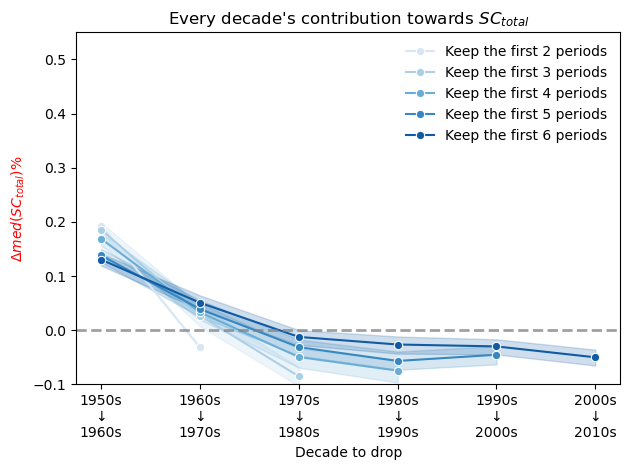

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = pd.DataFrame(columns=['Decade', 'Value', 'founded decade'])
for idx, founded_decade in enumerate(all_age_group_result_df['founded decade']):
    for decade in ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']:
        if all_age_group_result_df[decade][idx] is not None:
            temp_df = pd.DataFrame({
                'Decade': [decade] * len(all_age_group_result_df[decade][idx]),
                'Value': all_age_group_result_df[decade][idx].flatten(),
                'founded decade': [founded_decade] * len(all_age_group_result_df[decade][idx])
            })
            plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

plt.figure()
sns.lineplot(data=plot_data, x='Decade', y='Value', hue='founded decade', palette='Blues', errorbar='pi', marker='o')
ax = plt.gca()
xticks_v = ['1950s\n↓\n1960s', '1960s\n↓\n1970s','1970s\n↓\n1980s','1980s\n↓\n1990s','1990s\n↓\n2000s','2000s\n↓\n2010s']
ax.set_xticklabels(xticks_v)
ax.axhline(0, color='grey', alpha=0.75, linestyle='--', lw=2)

plt.title("Every decade's contribution towards $SC_{total}$")
plt.xlabel('Decade to drop')
ax.set_ylim(-0.1, 0.55)
plt.ylabel('$\Delta med(SC_{total})\%$', color='red')

plt.legend(frameon=False)
plt.tight_layout()
plt.show()

### Archive

In [ ]:
import random

start_idx = 0

sampling_df = local_semantic_change_df[local_semantic_change_df.start_idx==start_idx].copy()
sampling_df.drop(columns=['total_semantic_change_1960s', 'total_semantic_change_1970s', 'total_semantic_change_1980s',
                          'total_semantic_change_1990s', 'total_semantic_change_2000s', 'total_semantic_change_2010s'], inplace=True)

period_list = ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 
               'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']

n_iter = 1000
all_period_results = []
for period in period_list[start_idx:]:
    iter_results = []
    print('period to drop:', period)
    column_to_drop = period
    change_df = sampling_df.copy()
    change_df.drop(period, axis=1, inplace=True)

    remain_columns = period_list.copy()
    remain_columns.remove(period)
    print('remain columns:', remain_columns)

    print('start iteration...')
    for i in range(n_iter):
        random_change = random.choice(remain_columns)
        change_df[column_to_drop] = change_df[random_change] # use random change to replace the dropped column
        change_df['total_semantic_change_2010s'] = change_df[period_list].sum(axis=1)
        iter_results.append(change_df['total_semantic_change_2010s'].tolist())

    iter_results = np.array(iter_results)
    average_results = np.mean(iter_results, axis=0)
    all_period_results.append(average_results)

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

# plot distributions period by period
for i, data in enumerate(all_period_results):
    row, col = divmod(i, 3) # calculate row and column index

    sns.histplot(local_semantic_change_df[local_semantic_change_df.start_idx==start_idx].total_semantic_change_2010s, 
                 kde=True, ax=axes[row][col], binwidth=0.0075, alpha=0.35, element="step", color='blue', fill=False)
    sns.histplot(data, kde=True, ax=axes[row][col], binwidth=0.0075, alpha=0.35, element="step", color='#fa7602', fill=False)

    # indicate median value in the histogram
    median_original = local_semantic_change_df[local_semantic_change_df.start_idx==start_idx].total_semantic_change_2010s.median()
    median = np.median(data) 
    axes[row][col].axvline(median_original, color='blue', linestyle='--', label=f'original: {median_original:.4f}')
    axes[row][col].axvline(median, color='#fa7602', linestyle='--', label=f'bootstrap: {median:.4f}') 

    median_diff = median_original - median
    if median_diff > 0.005:
        axes[row][col].annotate('', xy=(median, 30), xytext=(median_original, 30), 
                     arrowprops=dict(arrowstyle="<->", color='red', lw=1))
        axes[row][col].text((median+median_original)/2+0.027, 20, f'$\Delta med(SC_{{total}})$ = {median_diff:.4f}', color='red', ha='center', va='center')
    
    axes[row][col].set_xlim(0.016, 0.115)

    axes[row][col].set_title(f'Drop {period_list[i+start_idx][-5:]} ({median_diff:.4f})')
    axes[row][col].set_xlabel('')
    axes[row][col].set_ylabel('')
    axes[row][col].legend(frameon=False)

print('Number of periodicals:', len(local_semantic_change_df[local_semantic_change_df.start_idx==start_idx]))

fig.supxlabel('Total semantic change till the 2010s ($SC_{total}$)')
fig.supylabel('count')

plt.tight_layout()
plt.show()

In [ ]:
median_diff_list = []
for median in median_list:
    median_diff_list.append(median_original - median)

xticklabels = []
for i in range(6-start_idx):
    xticklabels.append(f'{change_list[i+start_idx][-5:]}')

sns.lineplot(x=change_list[start_idx:], y=median_diff_list)
plt.xlabel('Decade to drop')
plt.ylabel('Midian Δ difference')
plt.xticks(ticks=change_list[start_idx:], labels=xticklabels)
plt.title('Every decade\'s contribution toward Δ')
plt.show()

In [ ]:
# 使用 melt 函数将 DataFrame 从宽格式转换为长格式
df_melted = median_diff_df.melt(id_vars='founded decade', 
                                var_name='Decade to drop', 
                                value_name='Median Δ Difference')

plt.figure()
sns.lineplot(data=df_melted, x='Decade to drop', y='Median Δ Difference', hue='founded decade', marker='o')

plt.title('Every decade\'s contribution towards Δ')
plt.ylabel('Median Δ Difference')
plt.xlabel('Decade to drop')

plt.legend(frameon=False)
plt.tight_layout()
plt.show()